In [1]:
import numpy as np
from quspin.basis import spin_basis_general # Hilbert spaces
from quspin.tools.measurements import obs_vs_time # calculating dynamics
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
from scipy.signal.windows import blackman
import hhg_functions as hhg

In [2]:
bc = 1      # 1 -- periodic boundary conditions, 0 -- open

''' physical parameters of the system '''
J = 2.0 # spin coupling
h = 6.0 # static magnetic field
B = 8.0 # magnetic field pulse amplitude
Omega = 1.0 # laser frequency
N_cycles = 9 # number of laser cycles

Lx, Ly = 3, 3 # system size
Nsites = Lx * Ly

params = {
    "bc": bc,
    "J": J,
    "h": h,
    "B": B,
    "Omega": Omega,
    "N_cycles": N_cycles,
    "Lx": Lx,
    "Ly": Ly,
    "Nsites": Nsites
    }

Tf = 2 * np.pi * N_cycles / Omega

print(f"Simulating Ising model:")
print(f"Lx x Ly = {Lx}x{Ly}, J={J}, h={h}, B={B}, ω={Omega}, N_cyc={N_cycles}")

T_x, T_y = hhg.create_translational_symmetry(Lx, Ly)

basis_2d = spin_basis_general(
    Nsites,
    pauli=0,
    kxblock=(T_x, 0),
    kyblock=(T_y, 0)
)

'''evolution time'''
dt = 0.05
start, stop = 0, Tf + 10
num = int(stop / dt)
t = np.linspace(start, stop, num=num, endpoint=True)

Simulating Ising model:
Lx x Ly = 3x3, J=2.0, h=6.0, B=8.0, ω=1.0, N_cyc=9


In [3]:
H = hhg.ising2d_hamiltonian(basis_2d, **params)
E0, psi0 = eigsh(H.toarray(), k=1, which='SA', maxiter=1E9)  # find ground state

psi_t = H.evolve(psi0, t[0], t, iterate=True)

observables = obs_vs_time(psi_t, t, dict(mag_x=hhg.magnetization(Nsites, basis_2d, operator='x'),
                                         mag_z=hhg.magnetization(Nsites, basis_2d, operator='z')
                                         ))
Mx = observables["mag_x"].real / Nsites
Mz = observables["mag_z"].real / Nsites

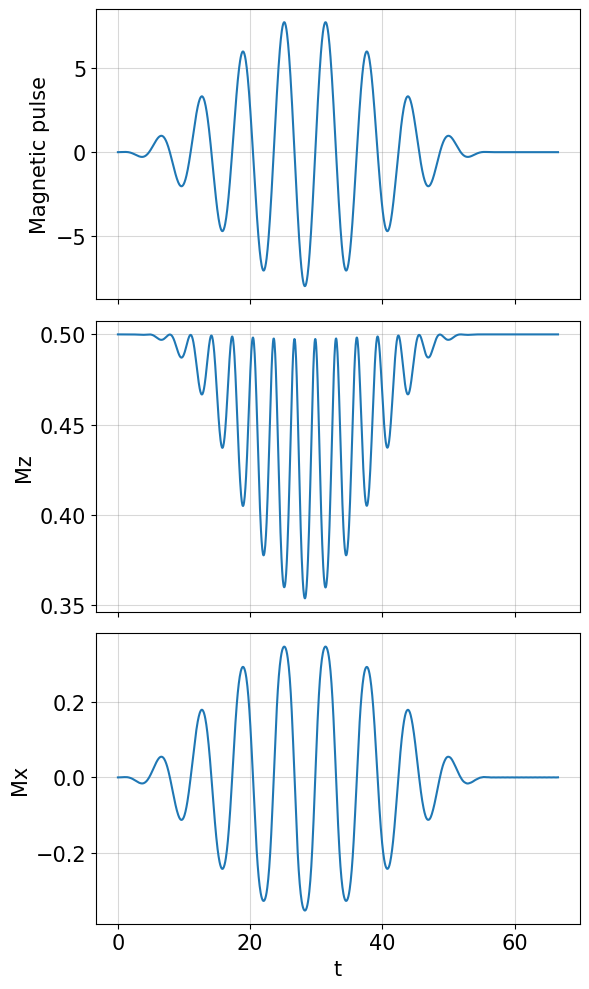

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# Panel 1: Magnetic pulse(t)
axs[0].plot(t, [hhg.magnetic_pulse(i, Omega, N_cycles, B) for i in t])
axs[0].set_ylabel("Magnetic pulse", fontsize=15)
axs[0].tick_params(axis="both", labelsize=15)
axs[0].grid(True, color="gray", alpha=0.3)

# Panel 2: Mz(t)
axs[1].plot(t, Mz)
axs[1].set_ylabel("Mz", fontsize=15)
axs[1].tick_params(axis="both", labelsize=15)
axs[1].grid(True, color="gray", alpha=0.3)

# Panel 3: Mx(t)
axs[2].plot(t, Mx)
axs[2].set_xlabel("t", fontsize=15)
axs[2].set_ylabel("Mx", fontsize=15)
axs[2].tick_params(axis="both", labelsize=15)
axs[2].grid(True, color="gray", alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
# compute power
# power ~ second derivative of magnetic dipole

Mxd2 = hhg.diff2(t, Mx)
Mzd2 = hhg.diff2(t, Mz)

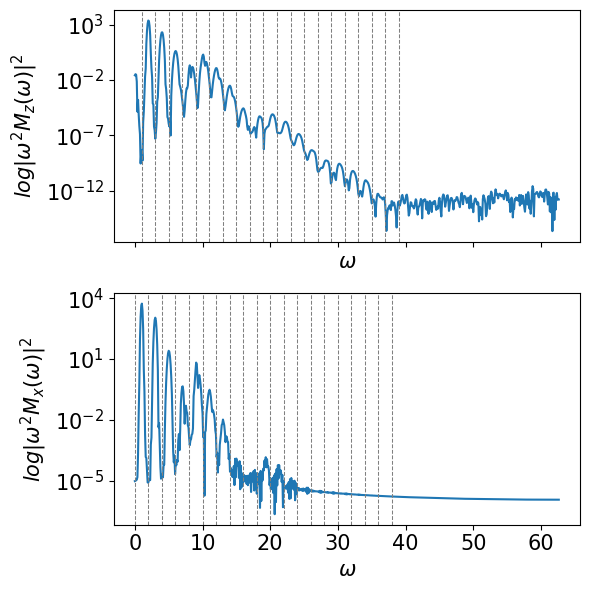

In [8]:
dt = t[1] - t[0]
freq = 2 * np.pi * np.fft.fftfreq(len(t), d=dt)
Mxd2_fft = np.fft.fft(Mxd2[:, 0] * hhg.blackman_window_paper(t, Tf))
Mzd2_fft = np.fft.fft(Mzd2[:, 0] * hhg.blackman_window_paper(t, Tf))

# Shift to center zero frequency
freq = np.fft.fftshift(freq)
Mxd2_fft = np.fft.fftshift(Mxd2_fft)
Mzd2_fft = np.fft.fftshift(Mzd2_fft)

mask = freq >= 0

fig, axs = plt.subplots(2, 1, figsize=(6,6), sharex=True)

# Panel 2: Mz(ω)
axs[0].semilogy(freq[mask], np.abs(Mzd2_fft[mask]) ** 2)
axs[0].set_xlabel(r"$\omega$", fontsize=15)
axs[0].set_ylabel(r"$log|\omega^2M_z(\omega)|^2$", fontsize=15)
axs[0].tick_params(axis="both", labelsize=15)
# axs[0].grid(True, color="gray", alpha=0.3)
for n in range(20):
    axs[0].axvline((2 * n + 1) * Omega, linestyle='--', color='gray', linewidth=0.75)

# Panel 3: Mx(ω)
axs[1].semilogy(freq[mask], np.abs(Mxd2_fft[mask]) ** 2)
axs[1].set_xlabel(r"$\omega$", fontsize=15)
axs[1].set_ylabel(r"$log|\omega^2M_x(\omega)|^2$", fontsize=15)
axs[1].tick_params(axis="both", labelsize=15)
# axs[1].grid(True, color="gray", alpha=0.3)
for n in range(20):
    axs[1].axvline((2 * n) * Omega, linestyle='--', color='gray', linewidth=0.75)

plt.tight_layout()
plt.show()
